In [104]:
from SimPEG import Mesh, Maps, Utils, EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP import getTau, DebyeDecProblem, DebyeDecSurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
%matplotlib inline
def ColeColePelton(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1-eta)*(1j*w*tau)**c))

In [199]:
taumin, taumax = 1e-10, 1e10
ntau = 101
mesh = getTau(taumin, taumax, ntau)
frequency = np.logspace(-8, 8, 161)

from SimPEG import (DataMisfit, Regularization, Inversion,
                    Optimization, InvProblem, Directives)
# wires = Maps.Wires(('sigmaInf', 1), ('eta', mesh.nN))
sigmaInf, eta, tau, c = 0.01, 0.5, 0.005, 0.7
# sigmap = Maps.ExpMap(nP=1)*wires.sigmaInf

# prb = DebyeDecProblem(mesh, sigmaInfMap = sigmap, etaMap = wires.eta, frequency=frequency)
prb = DebyeDecProblem(mesh, sigmaInf = sigmaInf, etaMap = Maps.IdentityMap(nP=ntau), frequency=frequency)
survey = DebyeDecSurvey()
prb.pair(survey)

Assume sigmaInf is known


In [200]:
# f = prb.fields(m)
# d = survey.dpred(m)
dobs = ColeColePelton(prb.frequency, sigmaInf, eta, tau, c) 
survey.dobs = np.r_[np.log(dobs).real, np.log(dobs).imag]
# m0 = np.r_[np.log(sigmaInf), np.zeros(prb.ntau)+1e-10]
m0 = np.r_[np.zeros(prb.ntau)+1e-10]
survey.std = 0.
survey.eps = np.r_[np.ones(prb.nfreq)*eta*0.003, np.ones(prb.nfreq)*0.003]
regmesh = Mesh.TensorMesh([m0.size])
# Now set up the problem to do some minimization
dmis = DataMisfit.l2_DataMisfit(survey)
target = Directives.TargetMisfit()
reg = Regularization.BaseRegularization(regmesh)
opt = Optimization.ProjectedGNCG(
    maxIterLS=20, maxIter=20, tolF=1e-6,
    tolX=1e-6, tolG=1e-6, maxIterCG=6
)
beta = Directives.BetaSchedule()
# opt.upper = np.r_[np.log(1e2), 1.*np.ones(prb.ntau)]
# opt.lower = np.r_[np.log(1e-6), 0.*np.ones(prb.ntau)]
opt.upper = np.r_[1.*np.ones(prb.ntau)]
opt.lower = np.r_[0.*np.ones(prb.ntau)]

invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e1)
inv = Inversion.BaseInversion(invProb, directiveList=[target])
mopt = inv.run(m0)


SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+01  9.94e+06  0.00e+00  9.94e+06    1.00e+01      0              
   1  1.00e+01  3.28e+06  3.36e-03  3.28e+06    2.24e+00      0              
   2  1.00e+01  7.57e+05  2.16e-03  7.57e+05    1.73e+00      0              
   3  1.00e+01  2.06e+05  8.04e-03  2.06e+05    1.42e+00      0              
   4  1.00e+01  1.38e+04  7.58e-03  1.38e+04    2.65e-01      0              
   5  1.00e+01  7.55e+03  9.09e-03  7.55e+03    1.35e-01      0              
   6  1.00e+01  2.89e+03  8.79e-03  2.89e+03    1.65e+0

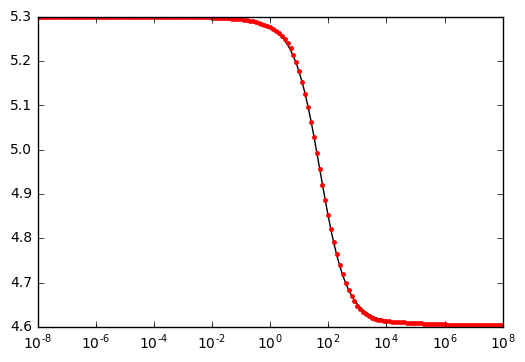

In [201]:
plt.semilogx(prb.frequency, -survey.dobs[:prb.nfreq], 'k')
plt.semilogx(prb.frequency, -invProb.dpred[:prb.nfreq], 'r.')

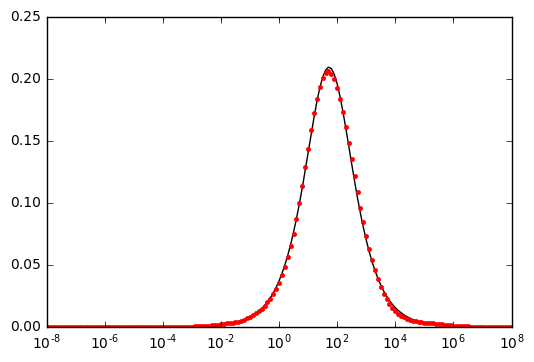

In [202]:
plt.semilogx(prb.frequency, survey.dobs[prb.nfreq:], 'k')
plt.semilogx(prb.frequency, invProb.dpred[prb.nfreq:], 'r.')

In [203]:
cs, ncx, ncz, npad = 5., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC)* 0.01
airind = mesh.gridCC[:,2]>0.
sigmaInf[airind] = 1e-8

In [204]:
# timeSteps = np.r_[np.ones(10)*1e-5, np.ones(10)*5e-5, np.ones(10)*1e-4, np.ones(10)*5e-4, ]
# times = np.r_[0., np.cumsum(timeSteps)]
# nstep = len(timeSteps)
# mopt[1:] = 0.

In [205]:
rxloc = np.array([[50.5, 0., 0.]])
srcloc = np.array([[0., 0., 0.]])

In [206]:
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(-4, -2.5, 11), 'z')
src = EM.TDEM.Src.MagDipole([rx], loc=srcloc)
survey = EM.TDEM.Survey([src])
prb_em = EM.TDEM.Problem3D_b(mesh, sigmaMap=Maps.IdentityMap(mesh))
prb_em.timeSteps = [(2.5e-06, 10), (5e-06, 10), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20) ]
Solver = PardisoSolver
survey.pair(prb_em)

In [207]:
from SimPEG.EM.TDEM import Fields3D_e
class FieldsTDEMIP_e_from_b(Fields3D_e):
    """Fancy Field Storage for a TDEM survey."""
    knownFields = {'eSolution': 'E'}
    aliasFields = {
                    'e': ['eSolution', 'E', '_e'],
                    'b': ['eSolution', 'F', '_b'],
                    'dbdt': ['eSolution', 'F', '_dbdt'],
                  }    
    def startup(self):
        pass

In [208]:
b0 = src.bInitial(prb_em)
e0 = np.zeros((mesh.nE,1))
j0 = np.zeros((mesh.nE,1))

C = mesh.edgeCurl
MfMui = mesh.getFaceInnerProduct(1./mu_0)
Me = mesh.getEdgeInnerProduct()
se_0 = C.T*MfMui*b0
se_0 = np.atleast_2d(se_0).T
prb_em.fieldsPair = FieldsTDEMIP_e_from_b
current = np.zeros_like(prb_em.times)
current[0] = 1.
timeSteps = prb_em.timeSteps

In [209]:
def getpetaI(time):   
    # TODO: generalize for multiple chargeable bodies
    return prb.get_petaImpulse(time, mopt)

def getKappa(dt):    
    temp = np.ones(mesh.nC)
    temp[airind] = 0.
    val = prb.get_petaStepon(dt, mopt) + prb.get_Expb(dt, mopt) / dt
    return sigmaInf * temp * val

def getGamma(dt):
    temp = np.ones(mesh.nC)
    temp[airind] = 0.    
    etas = mopt[1:] 
    eta = etas.sum()    
    val = -eta - prb.get_Expb(dt, mopt) / dt
    return sigmaInf * temp * val

def MeK(dt):
    kappa = getKappa(dt)
    return mesh.getEdgeInnerProduct(kappa)      

def MeA(dt):
    gamma = getGamma(dt)
    val = sigmaInf + gamma
    return mesh.getEdgeInnerProduct(val)      

def MeCnk(n, k):
    temp = np.ones(mesh.nC)
    temp[airind] = 0.    
    tn = prb_em.times[n]
    tk = prb_em.times[k]
    val = -sigmaInf* temp *getpetaI(tn-tk)
    return mesh.getEdgeInnerProduct(val)

def getA(tInd):
    """
        :param int tInd: Time index
        :rtype: scipy.sparse.csr_matrix
        :return: A
    """
    dt = timeSteps[tInd]  
    return C.T*MfMui*C + 1./dt * MeA(dt)
    
def getJpol(tInd, F):
    """
        Computation of polarization currents
    """
    dt = timeSteps[tInd]
#     jpol = (dt/2)*MeCnk(tInd+1,tInd)*F[:,'e',tInd]    
    jpol = MeK(dt)*F[:,'e',tInd]    
    for k in range(tInd): 
        dt = timeSteps[k]
        jpol += (dt/2)*MeCnk(tInd+1,k)*F[:,'e',k]
        jpol += (dt/2)*MeCnk(tInd+1,k+1)*F[:,'e',k+1]
    return jpol

def getRHS(tInd, F, jpoldiff):
    dt = timeSteps[tInd]   
    dtlast = timeSteps[tInd-1]   
    RHS = - 1./ dt * (se_0*(current[tInd+1]-current[tInd])) \
          + 1./ dt * MeA(dtlast) * F[:,'e',tInd] \
          - 1./ dt * jpoldiff
    return RHS

solverOpts = {}  
verbose = True

def forward(m, F):
    curModel = m
    dtFact = None
    Ainv   = None
    jpol_last= Me*j0
    for tInd, dt in enumerate(timeSteps):
        if dt != dtFact:
            dtFact = dt
            if Ainv is not None:
                Ainv.clean()
            A = getA(tInd)
            if verbose: print 'Factoring...   (dt = %e)'% dt
            Ainv = Solver(A, **solverOpts)
            if verbose: print 'Done'
        jpol = getJpol(tInd, F)    
        jpoldiff = jpol-jpol_last
        rhs = getRHS(tInd, F, jpoldiff)
        if verbose: print '    Solving...   (tInd = %d)'% tInd
        sol = Ainv * rhs  
        sol = np.atleast_2d(sol).T
        F[src, 'eSolution', tInd+1] = sol
        if verbose: print '    Done...'
#         Mej = MeA(dt)*sol + jpol
        jpol_last = jpol.copy()
    Ainv.clean()

In [210]:
F = prb_em.fieldsPair(mesh, survey)
F[src,'eSolution',0] = np.zeros(mesh.nE)
forward(True, F)

Factoring...   (dt = 2.500000e-06)
Done
    Solving...   (tInd = 0)
    Done...
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
Factoring...   (dt = 5.000000e-06)
Done
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    Done...
Factoring...   (dt = 1.000000e-05)
Done
    Solving...   (tInd = 20)
    Done...
    Solving...   (tInd = 21)


In [211]:
dbdt = C*F[src, 'eSolution', :]
Pfz = mesh.getInterpolationMat(rxloc, locType="Fz")

In [212]:
data = Pfz*dbdt

In [213]:
from EMTD.Utils import hzAnalyticDipoleT, hzAnalyticDipoleT_CC

In [214]:
Div = prb_em.timeMesh.faceDiv
hz = hzAnalyticDipoleT(rxloc[0][0], prb_em.timeMesh.gridFx, 0.01)
hzip = hzAnalyticDipoleT_CC(rxloc[0][0], prb_em.timeMesh.gridFx[1:], sigmaInf=0.01, eta=eta, tau=tau, c=c)
P = prb_em.timeMesh.getInterpolationMat(prb_em.times[10:])
dhzdt = P*Div*hz
dhzdtip = P*Div*np.r_[0., hzip]

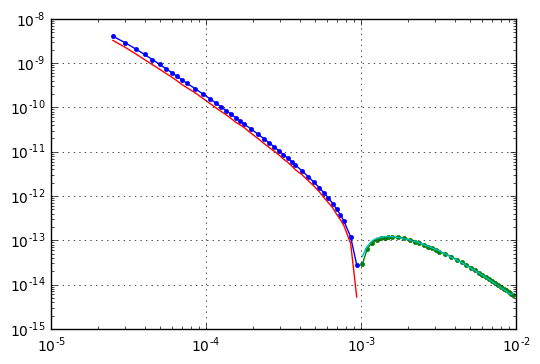

In [215]:
scale = 1.
plt.loglog(prb_em.times[10:], data.flatten()[10:], '.-')
plt.loglog(prb_em.times[10:], -data.flatten()[10:], '.-')
plt.loglog(prb_em.times[10:], -dhzdtip.flatten()*mu_0*scale, '-')
plt.loglog(prb_em.times[10:], dhzdtip.flatten()*mu_0*scale, '-')
# plt.loglog(prb_em.times[10:], -dhzdt.flatten()*mu_0)
plt.grid(True)